In [69]:
from ultralytics import YOLO
import cv2 as cv
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from scipy.signal import savgol_filter,butter,filtfilt
from collections import deque

In [70]:
localizer = YOLO("../models/Screen_Yolov8.pt").to("cuda")

In [103]:
localizer.names

{0: 'chest', 1: 'face', 2: 'nostril'}

In [ ]:
# Open the thermal video stream from device 0 using the V4L (Video4Linux) backend
cap = cv.VideoCapture("/dev/video0", cv.CAP_V4L)

# Disable RGB conversion, keep the native YUYV format
cap.set(cv.CAP_PROP_CONVERT_RGB, 0)

# Initialize a deque to store nasal respiration signal (max length 300 frames)
nasal_resp = deque(maxlen=500)
nasal_resp.append(0)  # Start with a zero value to avoid empty deque issues

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break  # Exit loop if frame capture fails

    # Split the captured frame into visible (imdata) and thermal (thdata) parts
    imdata, thdata = np.array_split(frame, 2)

    # Convert visible image from YUYV to BGR format for display
    imdata = cv.cvtColor(imdata, cv.COLOR_YUV2BGR_YUYV)
    
    # Flip vertically (may be required depending on camera orientation)
    imdata = cv.flip(imdata, 0)

    # Run object detection (e.g., YOLO) on the visible image
    results = localizer(imdata, verbose=False)

    # If any bounding boxes are detected
    if results[0].boxes.shape[0] != 0:
        # Extract box data (x1, y1, x2, y2, confidence, class)
        boxes = results[0].boxes.data.cpu().numpy()

        # Filter boxes for class '2' (2 is Nose class)
        noses = boxes[boxes[:, 5] == 2]

        # If any nose detections are found
        if noses.shape[0] != 0:
            # Choose the largest bounding box (by area) as the most prominent nose
            max_nose = np.argmax((noses[:, 3] - noses[:, 1]) * (noses[:, 2] - noses[:, 0]))
            xn1, yn1, xn2, yn2, conf, cls = map(int, noses[max_nose])

            # Compute the mean intensity in the nose region (proxy for nasal airflow)
            nasal_resp.append(np.mean(imdata[yn1:yn2, xn1:xn2]))
        else:
            # If no nose detected, repeat the last value to maintain continuity
            nasal_resp.append(nasal_resp[-1])

        # Draw bounding boxes for all detected objects
        for box in boxes:
            x1, y1, x2, y2, conf, cls = map(int, box)
            cv.rectangle(imdata, (x1, y1), (x2, y2), (0, 255, 0), 1)

        # Highlight the selected nose region in red
        if noses.shape[0] != 0:
            cv.rectangle(imdata, (xn1, yn1), (xn2, yn2), (0, 0, 255), 1)

    # Display the processed visible image
    cv.imshow('Thermal Image', imdata)

    # ============================================================================
    #                              TOO SLOW TO PLOT
    # ============================================================================
    # if len(nasal_resp) > 11:  
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(savgol_filter(nasal_resp, 11, 3), label='Nasal Respiration')
    #     plt.title('Nasal Respiration')
    #     plt.xlabel('Frame Number')
    #     plt.ylabel('Proxy for Nasal Airflow')
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.draw()
    #     plt_img = np.array(plt.gcf().canvas.buffer_rgba())
    #     plt.close()
    #     plt_img = cv.cvtColor(plt_img, cv.COLOR_RGBA2BGR)

    #     cv.imshow('Nasal Respiration Plot', plt_img)
    # ============================================================================


    # Dirty Way to Plot but Fast
    if len(nasal_resp) > 200 :
        # Filter and normalize the signal
        signal = savgol_filter(nasal_resp, 51, 3)
        signal = np.array(signal)[20:-25]
        signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-5)  # Normalize to 0-1

        # Plot settings
        plot_width = 600
        plot_height = 200
        plot_img = np.ones((plot_height, plot_width, 3), dtype=np.uint8) * 255

        # Convert signal to pixel coordinates
        points = []
        for i in range(1, len(signal)):
            x1 = int((i - 1) / len(signal) * plot_width)
            y1 = int((1 - signal[i - 1]) * plot_height)
            x2 = int(i / len(signal) * plot_width)
            y2 = int((1 - signal[i]) * plot_height)
            points.append(((x1, y1), (x2, y2)))

        # Draw signal as lines
        for pt1, pt2 in points:
            cv.line(plot_img, pt1, pt2, (255, 0, 0), 2)

        # Add labels (optional)
        cv.putText(plot_img, 'Nasal Respiration', (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

        # Show the plot
        cv.imshow('Nasal Respiration Plot', plot_img)


    # Wait for 1 ms and break loop if 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        cv.destroyAllWindows()
        cap.release()
        break

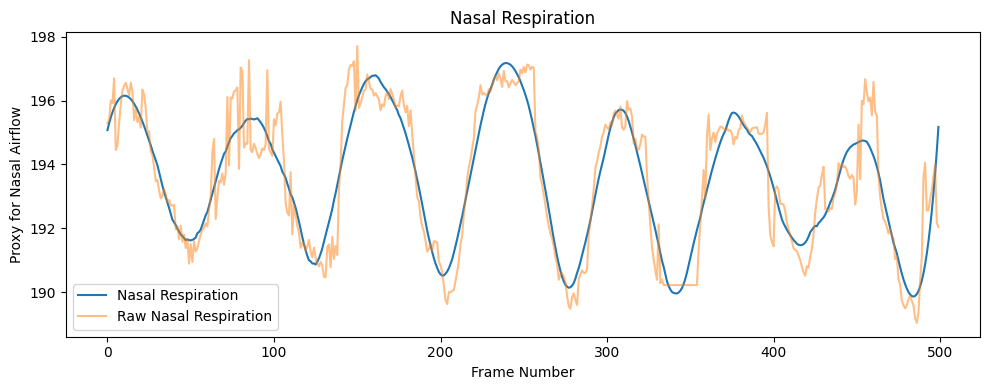

In [115]:
plt.figure(figsize=(10, 4))
plt.plot(savgol_filter(nasal_resp, 51, 3), label='Nasal Respiration')
plt.plot(nasal_resp, label='Raw Nasal Respiration', alpha=0.5)
plt.title('Nasal Respiration')
plt.xlabel('Frame Number')
plt.ylabel('Proxy for Nasal Airflow')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def band_pass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

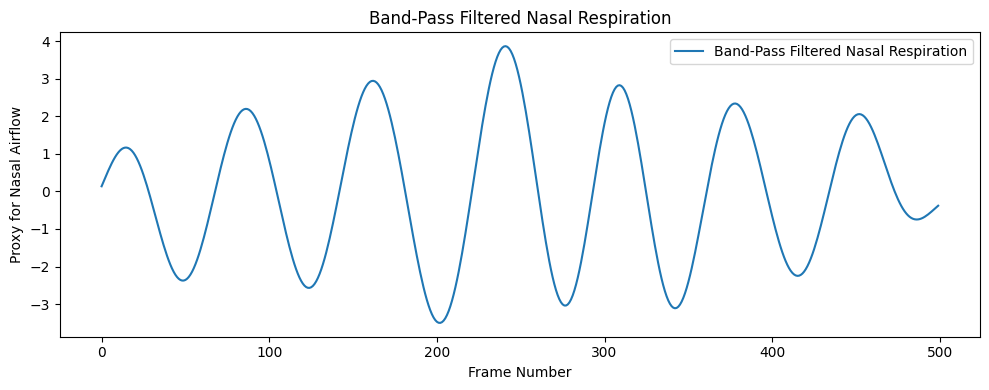

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(band_pass_filter(nasal_resp, 0.1, 0.5, 25), label='Band-Pass Filtered Nasal Respiration')
plt.title('Band-Pass Filtered Nasal Respiration')
plt.xlabel('Frame Number')
plt.ylabel('Proxy for Nasal Airflow')
plt.legend()
plt.tight_layout()
plt.show()